In [29]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

from models.arima import train_arima

In [30]:
# Load time series
dataset_name = "co2_emissions_coal"
dataset_folder = "datasets"
value_column = "Emissions [MMT]"

df = pd.read_csv(Path(dataset_folder) / dataset_name / f"{dataset_name}.csv", index_col="YYYYMM") 
ts = df[value_column]
ts.index = pd.to_datetime(ts.index)

# Split the series into training and test sets
result = seasonal_decompose(ts, model='additive')
ts_detrended = ts - result.trend
ts_detrended.dropna(inplace=True)

train, test = train_test_split(ts, test_size=0.5, shuffle=False)

In [31]:
arima = train_arima(
    train_data=train, 
    p_values=[1, 2, 3, 4, 5, 6], 
    d_values=[1, 2, 3, 4, 5, 6], 
    q_values=[1, 2]
)

                               SARIMAX Results                                
Dep. Variable:        Emissions [MMT]   No. Observations:                  261
Model:                 ARIMA(6, 1, 2)   Log Likelihood                -859.492
Date:                Wed, 12 Feb 2025   AIC                           1736.984
Time:                        08:32:18   BIC                           1769.030
Sample:                    01-01-1973   HQIC                          1749.867
                         - 09-01-1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0019      0.300      0.006      0.995      -0.585       0.589
ar.L2          0.0762      0.242      0.314      0.753      -0.399       0.551
ar.L3         -0.4256      0.084     -5.067      0.0

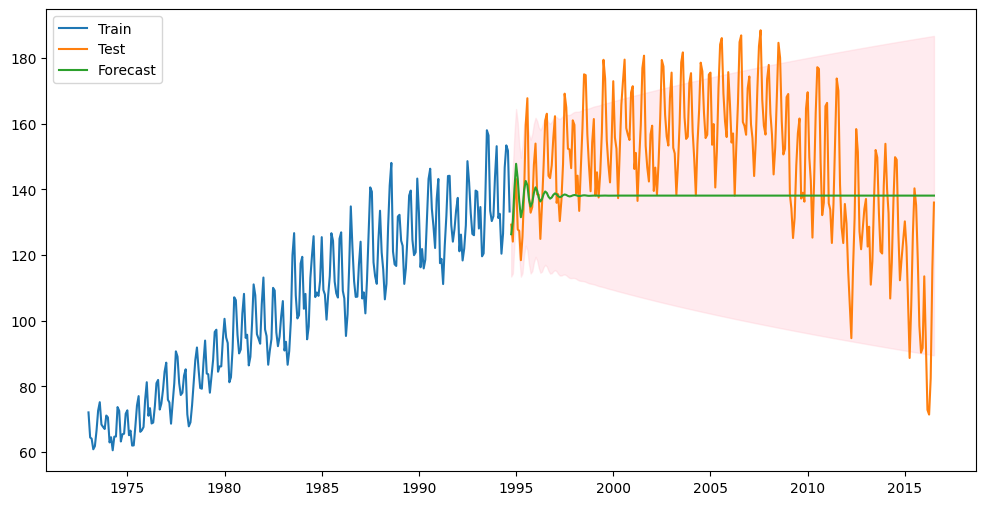

In [32]:
# Forecast the test data
forecast = arima.get_forecast(steps=len(test))
forecast_index = test.index
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
conf_int = forecast.conf_int()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()